# **Progetto di Tesi: Classificazione e Correzione delle pose di yoga**

Questo progetto si pone come obbiettivo quello di creare un sistema, che poi verrà utilizzato all'interno di una web-app, che permette la classificazione e la successiva correzione delle pose di yoga sia in real-time che in differita;

Pertanto questo progetto si articolerà in 2 fasi principali:

1. **Classificazione delle pose**
2. **Correzione delle pose**

## **1. Classificazione delle pose**

In questa prima fase del sistema verrà implementato un sistema che, come anticipato, permetterà la classificazione delle varie pose eseguite.

In questa fase non verrà utilizzato un solo modello per la classificazione ma verranno confrontati una serie di modelli, per determinare quale tra questi risulta il migliore non solo in termini di efficacia ma anche in termini di efficienza, ossia in relazione alla complessità spaziale e temporale e quindi alle risorse utilizzate.

I modelli confrontati saranno sia modelli di **Deep Learning**, sia modelli di **Machine Learning** più semplici:

- **SVM**
- **Random Forest**
- **LSTM**
- **GRU**
- **RNN**


Importo i moduli e le librerie di interesse, utili per la realizzazione di questa fase del sistema.

In [2]:
import cv2
import tensorflow as tf
import numpy as np
import os 
from matplotlib import pyplot as plt
import time
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

#Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,LSTM,Dense, GRU,SimpleRNN
from tensorflow.keras.callbacks import TensorBoard

#Metriche di valutazione
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

### **Dataset**

#### **Organizzazione & Analisi Esplorativa dei Dati video**

Il nostro dataset si compone di una serie di video(al momento 88) , rappresentati sia uomini che donne di diversa età, che svolgono diverse pose di yoga(al momento 6).

Tali video sono stati poi ripartiti manualmente in 6 diverse cartelle rappresentati le 6 diverse pose.

Per poter garantire una futura aggiunta di video e pose, sono stati realizzati una serie di script che permettono di lavorare con cartelle e file.

Innazitutto definiamo il percorso del nostro dataset

In [3]:
DATA_PATH = os.path.join('\progetto_tesi','dataset')
print(DATA_PATH)

\progetto_tesi\dataset


Raccogliamo le pose disponibili all'interno di una lista, in modo tale che in futuro sia più facile aggiungere nuove posizioni, sfruttando questa lista.

In particolare in questo momento avremo le seguenti 6 pose:

- **Cobra (Bhuj)**
- **Tree (Vriksh)**
- **Mountain (Tada)**
- **Lotus (Padam)**
- **Triangle (Trik)**
- **Corpse (Shav)**

In [4]:
dir_list = os.listdir(DATA_PATH) 
actions = dir_list
actions=np.array(actions)
print(actions)

['Cobra' 'Corpse' 'Lotus' 'Mountain' 'Tree' 'Triangle']


Creiamo una funzione che, sfruttando gli script prima creati, ci permetta di raccogliere tutti i video all'interno di una lista(il percorso dei video).

In [5]:
def get_video_list(data_path,actions):
        video_list = []
        for file in actions:
                file_path = os.path.join(DATA_PATH, file)
                
                for f in os.listdir(file_path):
                        name, ext = os.path.splitext(f)
                        if ext == '.mp4':
                                video_list.append(f)

        return video_list

Analizziamo ora il nostro dataset in maniera più approfondita, creando una serie di funzioni che ci permettarà una serie di informazioni che ci potranno risultare utili anche in fasi più avanzate del nostro sistema.

Definisco una funzione che mi permette di contare il numero di video presenti nel nostro dataset, per ognuna delle quali è stata creata, come anticipato prima, una cartella.

In [6]:
def count_videos(directory_path, actions):
    num_videos = 0
    for file in actions:
        file_path = os.path.join(directory_path, file)
        for f in os.listdir(file_path):
            name, ext = os.path.splitext(f)
            if ext == '.mp4':
                num_videos+=1
    return num_videos

    

Definisco la funzione che mi permette di ottenere per ogni video la seguente tupla:

**[nome video, frames totali, fps, durata in sec]**.

Pertanto questa funzione restituirà una matrice che raccoglierà tutte queste tuple per ogni tipo di posa:

**[nome posa [tupla precedente]]**

In [7]:
def videos_lenght(directory_path, actions):
    
    all_videos=[]
    for file in actions:
        file_path = os.path.join(directory_path, file)
        
        video_list = []
        for f in os.listdir(file_path):
            name, ext = os.path.splitext(f)
            if ext == '.mp4':
                video_list.append(f)
        
        directory_videos = []
        for video in video_list:
            video_path = os.path.join(file_path,video)
            
            cap = cv2.VideoCapture(video_path)   
            
            frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
            fps = cap.get(cv2.CAP_PROP_FPS)
            
            # calculate duration of the video
            seconds = round(frames / fps)

            directory_videos.append([video, int(frames), int(fps), int(seconds)])
            
            cap.release()
            
        all_videos.append([file, directory_videos])
        
    return all_videos
    
    
    

Osserviamo quindi il nostro dataset stampando il risultato delle due funzioni precedenti.

In [8]:
num_videos = count_videos(DATA_PATH, actions)
print(num_videos)

info_videos = videos_lenght(DATA_PATH, actions)
print(info_videos)


88
[['Cobra', [['Abhay_Bhuj.mp4', 545, 30, 18], ['Kaustuk_Bhuj.mp4', 1263, 30, 42], ['Santosh_Bhuj2.mp4', 932, 30, 31], ['Veena_Bhu.mp4', 1489, 30, 50], ['Ameya_Bhuj.mp4', 1413, 30, 47], ['Bhumi_Bhuj.mp4', 1227, 30, 41], ['deepa_bhujan.mp4', 1257, 30, 42], ['Dristi_Bhuj.mp4', 1607, 30, 54], ['Harshav_Bhuj.mp4', 1468, 30, 49], ['lakshmi_bhujang.mp4', 1254, 30, 42], ['Piyush_Bhuj.mp4', 1411, 30, 47], ['Pranshul_Bhuj.mp4', 1242, 30, 41], ['Rakesh_Bhuj.mp4', 1774, 30, 59], ['Santosh_Bhuj.mp4', 818, 30, 27], ['Sarthak_Bhuj.mp4', 1140, 30, 38], ['Shiv_bhuj.mp4', 1897, 30, 63]]], ['Corpse', [['Shiva_Shavasana.mp4', 1391, 30, 46], ['Dristi_Shav.mp4', 1764, 30, 59], ['Harshav_Shav.mp4', 1262, 30, 42], ['Piyush_Shav.mp4', 1247, 30, 42], ['Santosh_Shav.mp4', 929, 30, 31], ['Sathak_shav.mp4', 937, 30, 31], ['Veena_Shav.mp4', 1345, 30, 45], ['Abhay_Shav.mp4', 1307, 30, 44], ['Ameya_Shav.mp4', 1592, 30, 53], ['Bhumi_Shav.mp4', 1239, 30, 41], ['deepa_shava.mp4', 1258, 30, 42], ['Kaustuk_Shav.mp4', 16

In [9]:
info_videos=np.array(info_videos,dtype=object)

In [10]:
#info_videos[5][1][3][1]# tip_posa tuple/nomeposa qualetuple nome/frame/fps/

#### **Human Pose Estimation: MoveNet**

Il nostro dataset si compone di una serie di video ripartiti in diverse cartelle, a seconda della posa, in cui vengono eseguite le diverse pose.
Per poter effettuare però una classificazione dei video, dobbiamo affrontare il problema della **Human pose Estimation**.

Per risolvere tale problema si è decisio di utilizzare **MoveNet**:


**MoveNet** è un modello ultra veloce e preciso che rileva **17 punti chiave** di un corpo. Il modello è offerto su *TF Hub* con due varianti, note come *Lightning* e *Thunder*.
Lightning è destinato ad applicazioni critiche per la latenza, mentre Thunder è destinato ad applicazioni che richiedono un'elevata precisione. 
Entrambi i modelli funzionano più velocemente del tempo reale (oltre 30 FPS) sulla maggior parte dei desktop, laptop e telefoni moderni, il che si rivela fondamentale per le applicazioni di fitness, salute e benessere dal vivo.

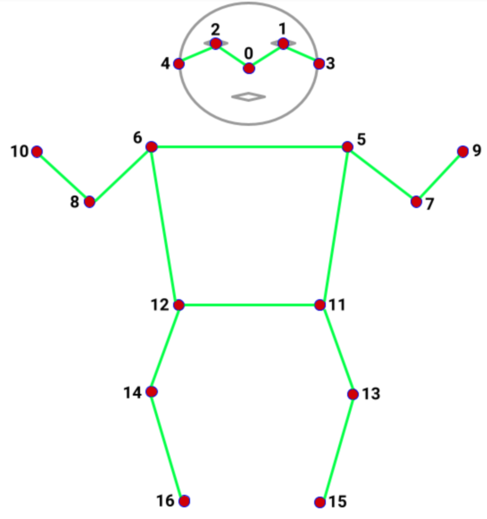

Carico il modello MoveNet scaricato dall'hub di tensorflow

In [11]:
# Initialize the TFLite interpreter
interpreter = tf.lite.Interpreter(model_path="lite-model_movenet_singlepose_thunder_3.tflite")
interpreter.allocate_tensors()

Definisco una funzione che effettui la predizioze dei landmarks che in questo caso saranno i joints

In [12]:
def movenet(input_image):
    
    input_image = tf.cast(input_image, dtype = tf.float32)
        
    # Setup input and output
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Make Predictions
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    
    return keypoints_with_scores

    

Definisco un dizionario che mappi i joint trovati al corrispettivo termine che rappresenta il joint.

In [13]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

Poichè movenet lavora con immagini in input di dimensione molto bassa affinchè funzioni in maniera corretta, specialmente nel caso dei video definisco una serie di funzioni che mi permette di croppare le immagini sul soggetto di interesse, in modo tale che i keypoint vengano individuati in maniera corretta.

In [14]:
# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
  """Defines the default crop region.

  The function provides the initial crop region (pads the full image from both
  sides to make it a square image) when the algorithm cannot reliably determine
  the crop region from the previous frame.
  """
  if image_width > image_height:
    box_height = image_width / image_height
    box_width = 1.0
    y_min = (image_height / 2 - image_width / 2) / image_height
    x_min = 0.0
  else:
    box_height = 1.0
    box_width = image_height / image_width
    y_min = 0.0
    x_min = (image_width / 2 - image_height / 2) / image_width

  return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
  }

def torso_visible(keypoints):
  """Checks whether there are enough torso keypoints.

  This function checks whether the model is confident at predicting one of the
  shoulders/hips which is required to determine a good crop region.
  """
  return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
  """Calculates the maximum distance from each keypoints to the center location.

  The function returns the maximum distances from the two sets of keypoints:
  full 17 keypoints and 4 torso keypoints. The returned information will be
  used to determine the crop size. See determineCropRegion for more detail.
  """
  torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
  max_torso_yrange = 0.0
  max_torso_xrange = 0.0
  for joint in torso_joints:
    dist_y = abs(center_y - target_keypoints[joint][0])
    dist_x = abs(center_x - target_keypoints[joint][1])
    if dist_y > max_torso_yrange:
      max_torso_yrange = dist_y
    if dist_x > max_torso_xrange:
      max_torso_xrange = dist_x

  max_body_yrange = 0.0
  max_body_xrange = 0.0
  for joint in KEYPOINT_DICT.keys():
    if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
      continue
    dist_y = abs(center_y - target_keypoints[joint][0]);
    dist_x = abs(center_x - target_keypoints[joint][1]);
    if dist_y > max_body_yrange:
      max_body_yrange = dist_y

    if dist_x > max_body_xrange:
      max_body_xrange = dist_x

  return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(
      keypoints, image_height,
      image_width):
  """Determines the region to crop the image for the model to run inference on.

  The algorithm uses the detected joints from the previous frame to estimate
  the square region that encloses the full body of the target person and
  centers at the midpoint of two hip joints. The crop size is determined by
  the distances between each joints and the center point.
  When the model is not confident with the four torso joint predictions, the
  function returns a default crop which is the full image padded to square.
  """
  target_keypoints = {}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint] = [
      keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
      keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
    ]

  if torso_visible(keypoints):
    center_y = (target_keypoints['left_hip'][0] +
                target_keypoints['right_hip'][0]) / 2;
    center_x = (target_keypoints['left_hip'][1] +
                target_keypoints['right_hip'][1]) / 2;

    (max_torso_yrange, max_torso_xrange,
      max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
          keypoints, target_keypoints, center_y, center_x)

    crop_length_half = np.amax(
        [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
          max_body_yrange * 1.2, max_body_xrange * 1.2])

    tmp = np.array(
        [center_x, image_width - center_x, center_y, image_height - center_y])
    crop_length_half = np.amin(
        [crop_length_half, np.amax(tmp)]);

    crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

    if crop_length_half > max(image_width, image_height) / 2:
      return init_crop_region(image_height, image_width)
    else:
      crop_length = crop_length_half * 2;
      return {
        'y_min': crop_corner[0] / image_height,
        'x_min': crop_corner[1] / image_width,
        'y_max': (crop_corner[0] + crop_length) / image_height,
        'x_max': (crop_corner[1] + crop_length) / image_width,
        'height': (crop_corner[0] + crop_length) / image_height -
            crop_corner[0] / image_height,
        'width': (crop_corner[1] + crop_length) / image_width -
            crop_corner[1] / image_width
      }
  else:
    return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  return output_image

Definisco la funzione che faccia l'inferenza sull'immagine/video dopo aver effettuato il crop.

In [15]:
def run_inference(movenet, image, crop_region, crop_size):
  """Runs model inferece on the cropped region.

  The function runs the model inference on the cropped region and updates the
  model output to the original image coordinate system.
  """
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  # Run model inference.
  keypoints_with_scores = movenet(input_image)
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height +
        crop_region['height'] * image_height *
        keypoints_with_scores[0, 0, idx, 0]) / image_height
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width +
        crop_region['width'] * image_width *
        keypoints_with_scores[0, 0, idx, 1]) / image_width
  return keypoints_with_scores

Per poter mostare a schermo lo scheletro del corpo umano, definito dai 17 punti e dagli che collegano questi ultimi defino 2 funzioni, una per i punti e una per gli archi.


Definisco la funzione che disegni i landmarks su schermo. 
Come si può notare dal codice i landmarks calcolati devono essere denomalizzati per ottenere la loro effettiva posizione su schermo.

In [16]:
def draw_keypoints(frame, keypoints, threshold):
        
    y, x, c = frame.shape
    # Denormalize the coordinates : multiply the normalized coordinates by the input_size(width,height)
    denormalized_coordinates = np.squeeze(np.multiply(keypoints, [y,x,1]))
    # Iterate through the points
    for keypoint in denormalized_coordinates:
        # Unpack the keypoint values : y, x, confidence score
        keypoint_y, keypoint_x, keypoint_confidence = keypoint
        if keypoint_confidence > threshold:
     
            cv2.circle(
                img=frame, 
                center=(int(keypoint_x), int(keypoint_y)), 
                radius=3, 
                color=(255,0,0),
                thickness=-1
            )

Definisco la funzione che disegna gli archi che collegano i vari joints su schermo.
Prima di andare a definire tale funzione però, definisco il dizionario che per ogni coppia di joints, assegna un colore, che verrà poi usato all'interno della funzione.

*La definzione delle coppe si trova nella doc*.

In [17]:
cyan = (255, 255, 0)
magenta = (255, 0, 255)

EDGE_COLORS = {
    (0, 1): magenta,
    (0, 2): cyan,
    (1, 3): magenta,
    (2, 4): cyan,
    (0, 5): magenta,
    (0, 6): cyan,
    (5, 7): magenta,
    (7, 9): cyan,
    (6, 8): magenta,
    (8, 10): cyan,
    (5, 6): magenta,
    (5, 11): cyan,
    (6, 12): magenta,
    (11, 12): cyan,
    (11, 13): magenta,
    (13, 15): cyan,
    (12, 14): magenta,
    (14, 16): cyan
}

In [18]:
def draw_edges(denormalized_coordinates,keypoints, frame, edges_colors, threshold):
    
    y,x,c = frame.shape
    denormalized_coordinates = np.squeeze(np.multiply(keypoints, [y,x,1]))
    # Iterate through the edges 
    for edge, color in edges_colors.items():
        # Get the dict value associated to the actual edge
        p1, p2 = edge
        # Get the points
        y1, x1, confidence_1 = denormalized_coordinates[p1]
        y2, x2, confidence_2 = denormalized_coordinates[p2]
        # Draw the line from point 1 to point 2, the confidence > threshold
        if (confidence_1 > threshold) & (confidence_2 > threshold):      
            cv2.line(
                img=frame, 
                pt1=(int(x1), int(y1)),
                pt2=(int(x2), int(y2)), 
                color=color, 
                thickness=1, 
                lineType=cv2.LINE_AA # Gives anti-aliased (smoothed) line which looks great for curves
            )

Definisco ora una funzione che metta insieme le due funzioni e che effettui quindi il render sia dei punti che degli archi, ossia dello scheletro.

In [19]:
def draw_skeleton(frame, keypoints_with_scores, threshold):
        draw_keypoints(frame , keypoints_with_scores, threshold)
        draw_edges(frame,keypoints_with_scores, frame, EDGE_COLORS, threshold)

#### **Creazione del dataset**

Arrivati a questo punto inizia la parte di creazione del nostro dataset effttivo, che non sarà composto da video o frames ma dai landmarks individuati e restituiti da MoveNet.

Definisco ora una funzione che effettui l'estrazione dei landmarks;

Movenet, per ogni frame restituirà un tensore pertanto trasformo questo tensore in un array bidimensionale che avrà 17 righe corrispondenti ai 17 joints e 3 colonne corrispondenti a x, y e confidence.

Rendiamo poi il nostro vettore a 2 dimensioni flatten ossia ad una dimensione.
Tale vettore sarà poi ritornato dalla funzione.

Quindi saremo passati da:
- **(1, 1, 17, 3)**
- **(17, 3)**
- **(51,)**


Abbiamo reso il nostro vettore a 2 dimensioni flatten ossia ad una dimensione, perchè le LSTM lavorano con questo tipo di input.

In [20]:
def extract_keypoints(keypoints_with_scores):
    pose = []
    i=0
    while i < len(keypoints_with_scores[0][0][:]):
        #row che sarà composta da x y e confidence dell' i-esimo keypoint/joint
        row = np.array([keypoints_with_scores[0][0][i][0], keypoints_with_scores[0][0][i][1], keypoints_with_scores[0][0][i][2]])
        pose.append(row)
        i+=1
    #redo il vettore a 1D
    pose = np.array(pose).flatten()
    return pose

Per organizzare i nostri dati in maniera ordinata e congrua all'organizzazione fino ad ora vista,
definisco una funzione che creai una cartella per ogni video, nominata con "nome video + _landmarks",all'interno della quale verranno salvati i keypoint raccolti per ogni frame.

In [21]:
def make_dir_keypoints(directory_path, actions):
    for file in actions:
        file_path = os.path.join(directory_path, file)
        
        video_list = []
        for f in os.listdir(file_path):
            name, ext = os.path.splitext(f)
            if ext == '.mp4':
                video_list.append(f)

        #se esiste già salta
        for video in video_list:
            try:
                os.makedirs(os.path.join(file_path, video +"_landmarks"))
            except:
                pass



In [22]:
make_dir_keypoints(DATA_PATH,actions)

codice per elimnare cartelle create

for file in actions:
        
    file_path = os.path.join(DATA_PATH, file)
    video_list = os.listdir(file_path)

    video_list = []
    for f in os.listdir(file_path):
        name, ext = os.path.splitext(f)
        if ext == '.npy':
            video_list.append(f)
    
    for video in video_list:
        os.remove(os.path.join(file_path, video))


for file in actions:
        
    file_path = os.path.join(DATA_PATH, file)
    video_list = os.listdir(file_path)

    cartella_list = os.listdir(file_path)
    
    for cartella in cartella_list:
        os.remove(os.path.join(file_path, cartella))

for file in actions:
        
    file_path = os.path.join(DATA_PATH, file)
    video_list = os.listdir(file_path)

    cartelle = []
    for f in os.listdir(file_path):
        name, ext = os.path.splitext(f)
        if not ext == '.mp4':
            cartelle.append(f)
    
   
    for cartella in cartelle:
        try:
            os.remove(os.path.join(file_path,cartella, "23.npy"))
        except:
            pass

Definisco ora la funzione che andrà a creare effettivamente il nostro dataset, composto da keyoints.
I keypoinyts, per ogni frame verranno salvati sottoforma di numpy array all'interno delle cartelle sopra create.

In [23]:
def extract_all_keypoints(directory_path,actions):
     for file in actions:
        
        file_path = os.path.join(directory_path, file)

        video_list = []
        for f in os.listdir(file_path):
            name, ext = os.path.splitext(f)
            if ext == '.mp4':
                video_list.append(f)
    
        for video in video_list:
            
            video_path = os.path.join(file_path,video) 
            cap = cv2.VideoCapture(video_path)
            
            #Ottengo il numero di frames totali
            video_frames_count= int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                        
            video_height, video_width = [768, 1366]# sostituire con funzione
            crop_region = init_crop_region(video_height, video_width)
            
            i=1
       
            for frame_counter in range(video_frames_count):
                try:                
                    #leggo il frame               
                    ret,frame = cap.read()
                    
                    #se non viene letto esco
                    if not ret:
                        break
                    
                    image = frame.copy()
                    cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                    keypoints_with_scores = run_inference(
                    movenet, image, crop_region,
                    crop_size=[256, 256])# sostituire con variabile

                    crop_region = determine_crop_region(
                    keypoints_with_scores, video_height, video_width)
                    
                    keypoints = extract_keypoints(keypoints_with_scores)
                
                    npy_path = os.path.join(file_path,video +"_landmarks",str(i))
                    np.save(npy_path, keypoints)                                        
                    i+=1
                    print(i)
                    print(npy_path)
                except:
                    pass

            cap.release()
            cv2.destroyAllWindows()



extract_all_keypoints(DATA_PATH,actions)

### **Divisione del Dataset**


Andiamo a definire un dizionrio che associa ad ogni video una label, che andrà a indicare la classe di appartenenza.

In [24]:
label_map = {label: num for num, label in enumerate(actions)}


In [25]:
label_map

{'Cobra': 0, 'Corpse': 1, 'Lotus': 2, 'Mountain': 3, 'Tree': 4, 'Triangle': 5}

In particolare si è deciso di dividere i frames di ogni video in subset di 45 frames, ed assegnare ad ognuno di questi una label.

Inoltre creo un vettore dove saranno indicati tramite un identificativo numerico quale delle persone presenti nel dataset sta svolgendo l'esercizio.Poichè questo vettore potrà risultare utile per test futuri. 

In [81]:
#creare una funzione
sequences=[]
group_sequences=[]
group=[]
labels=[]
j=0
for file in actions:
        file_path = os.path.join(DATA_PATH, file)
        
        key_dir_list = []
        for f in os.listdir(file_path):
            name, ext = os.path.splitext(f)
            if not ext == '.mp4':
                key_dir_list.append(f)
                

        i=0
        for keypoint_dir in key_dir_list:
            window = []
            for frame_num in range(1, info_videos[j][1][i][1]):
                group=[x for x in range(len(key_dir_list))]
                frame_path = np.load(os.path.join(file_path,keypoint_dir,"{}.npy".format(frame_num)))
                window.append(frame_path)
                if frame_num%45==0:    
                    sequences.append(window)
                    group_sequences.append(group[i])
                    labels.append(label_map[file])
                    window=[]                             
                    
            i+=1
        j+=1

In questo modo avremo quindi un array composto da 2599 video, ognuno dei quali composto da 45 framese.
Per ogni frame sono stati calcolati 17 keypoints ognuno composto da x y e c ossia 51 punti, essendo 51 = 17*3

In [82]:
np.array(sequences).shape

(2599, 45, 51)

Allo stesso modo ora tutti i vettori di keypoints rappresentati il video avranno la label corrispondente alla posa

In [44]:
np.array(labels).shape

(2599,)

Ho quindi creato una colonna rappresentante la persona che sta eseguendo il video.Pertanto la dimensione(il numero di righe) corrisponde al numero di video eseguiti

In [83]:
np.array(group_sequences).shape

(2599,)

Quindi ora avremo le nostre **feature input** e la nostra **feature target**

In [93]:
X = np.array(sequences)

In [94]:
y = np.array(labels)

Osserviamo come il nostro dataset sia bilanciato

Cobra 0: 454
Corpse 1: 447
Lotus 2: 391
Mountain 3: 438
Tree 4: 485
Triangle 5: 384
Percentage of 0: 17.47
Percentage of 1: 17.2
Percentage of 2: 15.040000000000001
Percentage of 3: 16.85
Percentage of 4: 18.66
Percentage of 5: 14.77


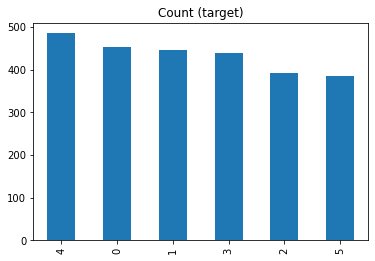

In [247]:
target_count=pd.DataFrame(data=y)[0].value_counts()
print(f'Cobra 0: {target_count[0]}')
print(f'Corpse 1: {target_count[1]}')
print(f'Lotus 2: {target_count[2]}')
print(f'Mountain 3: {target_count[3]}')
print(f'Tree 4: {target_count[4]}')
print(f'Triangle 5: {target_count[5]}')
print(f'Percentage of 0: {round(target_count[0] / sum(target_count), 4)*100}')
print(f'Percentage of 1: {round(target_count[1] / sum(target_count), 4)*100}')
print(f'Percentage of 2: {round(target_count[2] / sum(target_count), 4)*100}')
print(f'Percentage of 3: {round(target_count[3] / sum(target_count), 4)*100}')
print(f'Percentage of 4: {round(target_count[4] / sum(target_count), 4)*100}')
print(f'Percentage of 5: {round(target_count[5] / sum(target_count), 4)*100}')


target_count.plot(kind='bar', title='Count (target)')

Splittiamo effetivamente i nostri dati

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=11)

Osseviamo la dimensione del nostro set di train e di test:
- 520 video per il test
- 2079 video per il train

In [249]:

print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)


(520, 45, 51)
(2079, 45, 51)
(520,)
(2079,)


### **Costruzione dei modelli & Addestramento**

Definiamo gli import che andremo ad utilizzare

In [256]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, LeaveOneGroupOut

from sklearn.utils import shuffle

Valuteremo i modelli sulle seguenti metriche:

- accuracy
- recall
- precision
- f1

#### **Classificazione con modelli semplici di ML**

Per poter addestrare modelli di ML, come i seguenti, devo modificare la struttura delle nostre input features.
In particolare dovremo passare da una struttura a 3 dimensioni ad una struttura a 2 dimensioni

In [250]:
X_train_ML = X_train.reshape(2079,(45*51))

In [251]:
X_test_ML = X_test.reshape(520,(45*51))

In [252]:
print(X_train_ML.shape)
print(X_test_ML.shape)

(2079, 2295)
(520, 2295)


Per effettuare le classificazione definiremo una pipeline all'interno della quale andremo adefinire il classifier , ossia il modello utilizzato.

Inoltre prima della fase di test, per questi modelli effettueremo una fase di validation in cui verrà effettuata una stratify cross validation, in modo tale che le proporzioni tra le varie classi rimangano le stess.
Grazie a queste fase riuscire ad ottenere il modello con i settings migliori.

##### **Classificazione con SVM**

Definiamo la pipeline

In [ ]:
pipeline = imbpipeline(steps = [['classifier',SVC(kernel=None,
                                                  gamma=None, 
                                                  C=None)]])

Creiamo un'istanza della classe StratifiedKFold che ci permette di andare a definire un tipo di Cross Validation

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

Definiamo l'insieme degli iper-parametri, su cui verrà effettuato un tuning durante la fase di test.

Definiamo anche un'istanza di GridSearchCV, che ci permetterà ci combinare la cross validation con la pipeline.

In [ ]:
# in param_grid sono definiti gli iperparametri
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']
              }

new_params = {'classifier__' + key: param_grid[key] for key in param_grid}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1)

Adattiamo il nostro modello di training sul set di training e runniamo la funzione grid_search.fit, al termine della quale otterremo il modello migliore.

In [ ]:
# troviamo il modello migliore
grid_search.fit(X_train_ML, y_train)

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best parameters: {'classifier__C': 10, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}
Cross-validation score: 0.987974987974988


Passiamo in seguito alla fase di test e prediciamo le classi di abitabilità sui campioni X_test.

In [ ]:
# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test_ML)

accuracy: 0.9826923076923076
precision: 0.9839426523297491
recall: 0.98250589616569
f1: 0.9830119080797531


[]

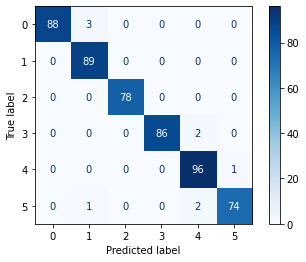

In [ ]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')

ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')


plt.plot()

In [ ]:
scoring_list = []
scoring_list.append(dict([
    ('Model', 'SVM'),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3))]))

##### **Classificazione con Random Forest**

In [ ]:
pipeline = imbpipeline(steps = [['classifier', RandomForestClassifier(max_depth=None, random_state=None)]]) #decidete se mettere q

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=12)

In [ ]:
# in param_grid sono definiti gli iperparametri
param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [4, 6, 10, 12],
                }

new_params = {'classifier__' + key: param_grid[key] for key in param_grid}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

In [ ]:
# troviamo il modello migliore
grid_search.fit(X_train_ML, y_train)

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 200}
Cross-validation score: 0.9855699855699855


In [ ]:
# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test_ML)

accuracy: 0.9769230769230769
precision: 0.9792209840178696
recall: 0.9767320694286985
f1: 0.9775113777577754


[]

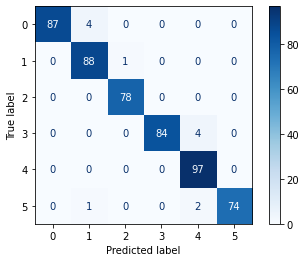

In [ ]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')

ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')


plt.plot()

In [ ]:
scoring_list.append(dict([
    ('Model', 'Random Forest'),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3))
     ]))

#### **Classificazione con modelli di DL**

Come già anticipato keras nel caso si tratti di feautures target, lavora con la codifica One-Hot, pertanto modifichiamo le noste target features.

In [253]:
y_test_DL = to_categorical(y_test).astype(int)
y_train_DL= to_categorical(y_train).astype(int)

In [254]:
print(y_test_DL.shape)
print(y_train_DL.shape)

(520, 6)
(2079, 6)


##### **Classificazione con Simple RNN**

In [ ]:
log_dir =os.path.join("\\progetto_tesi",'Logs_RNN')
tb_callback = TensorBoard(log_dir = log_dir)

In [ ]:
#definiamo l'architettura del modello
model_Rnn= Sequential()

model_Rnn.add(SimpleRNN(64, return_sequences=True, activation='relu', input_shape=(45,51)))
model_Rnn.add(SimpleRNN(128, return_sequences=True, activation='relu'))
model_Rnn.add(SimpleRNN(64, return_sequences=False, activation='relu'))
model_Rnn.add(Dense(64, activation='relu'))
model_Rnn.add(Dense(32, activation='relu'))
model_Rnn.add(Dense(actions.shape[0], activation='softmax'))

In [ ]:
model_Rnn.compile(optimizer ='Adam', 
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
rnn_h=model_Rnn.fit(X_train, y_train_DL, epochs=100, callbacks =[tb_callback])

Epoch 1/100
65/65 [==============================] - 12s 52ms/step - loss: 0.9797 - categorical_accuracy: 0.6171
Epoch 2/100
65/65 [==============================] - 3s 46ms/step - loss: 0.4009 - categorical_accuracy: 0.8475
Epoch 3/100
65/65 [==============================] - 3s 43ms/step - loss: 0.2685 - categorical_accuracy: 0.9192
Epoch 4/100
65/65 [==============================] - 3s 44ms/step - loss: 0.2087 - categorical_accuracy: 0.9365
Epoch 5/100
65/65 [==============================] - 2s 35ms/step - loss: 0.1945 - categorical_accuracy: 0.9432
Epoch 6/100
65/65 [==============================] - 3s 39ms/step - loss: 0.1545 - categorical_accuracy: 0.9582
Epoch 7/100
65/65 [==============================] - 2s 38ms/step - loss: 0.1343 - categorical_accuracy: 0.9610
Epoch 8/100
65/65 [==============================] - 2s 36ms/step - loss: 0.1307 - categorical_accuracy: 0.9668
Epoch 9/100
65/65 [==============================] - 3s 38ms/step - loss: 0.0951 - categorical_accuracy

In [ ]:
model_Rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 45, 64)            7424      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 45, 128)           24704     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
Total params: 50,918
Trainable params: 50,918
Non-traina

In [ ]:
y_test_predict = model_Rnn.predict(X_test)

17/17 [==============================] - 1s 12ms/step


accuracy: 0.9788461538461538
accuracy: 0.9788461538461538
precision: 0.9785364816472873
recall: 0.9794547246837876
f1: 0.9789239511677909


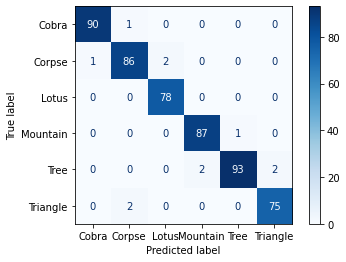

In [ ]:
accuracy = accuracy_score(actions[np.argmax(y_test_DL,axis =1).tolist()],
                          actions[np.argmax(y_test_predict, axis=1).tolist()])

precision = precision_score(actions[np.argmax(y_test_DL,axis =1).tolist()],
                            actions[np.argmax(y_test_predict, axis=1).tolist()],
                            average='macro')

recall = recall_score(actions[np.argmax(y_test_DL,axis =1).tolist()],
                      actions[np.argmax(y_test_predict, axis=1).tolist()],
                      average='macro')

f1 = f1_score(actions[np.argmax(y_test_DL,axis =1).tolist()],
              actions[np.argmax(y_test_predict, axis=1).tolist()],
              average='macro')


ConfusionMatrixDisplay.from_predictions(actions[np.argmax(y_test_DL,axis =1).tolist()], 
                                        actions[np.argmax(y_test_predict, axis=1).tolist()], 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')

In [ ]:
scoring_list.append(dict([
    ('Model', 'RNN'),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3))
     ]))

In [ ]:
model_Rnn.save('/progetto_tesi/model_RNN/')

INFO:tensorflow:Assets written to: /progetto_tesi/model_RNN/assets


INFO:tensorflow:Assets written to: /progetto_tesi/model_RNN/assets


##### **Classificazione con LSTM**

In [ ]:
log_dir_lst =os.path.join("\\progetto_tesi",'Logs_LSTM')
tb_callback = TensorBoard(log_dir = log_dir_lst)

In [ ]:
model_lstm= Sequential()

model_lstm.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(45,51)))
model_lstm.add(LSTM(128, return_sequences=True, activation='relu'))
model_lstm.add(LSTM(64, return_sequences=False, activation='relu'))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(actions.shape[0], activation='softmax'))

In [ ]:
model_lstm.compile(optimizer ='Adam', 
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
lstm_h=model_lstm.fit(X_train, y_train_DL, epochs=100, callbacks =[tb_callback])

Epoch 1/100
65/65 [==============================] - 18s 143ms/step - loss: 1.4115 - categorical_accuracy: 0.4815
Epoch 2/100
65/65 [==============================] - 9s 145ms/step - loss: 0.7404 - categorical_accuracy: 0.6989
Epoch 3/100
65/65 [==============================] - 10s 155ms/step - loss: 0.8166 - categorical_accuracy: 0.6898
Epoch 4/100
65/65 [==============================] - 9s 140ms/step - loss: 0.5626 - categorical_accuracy: 0.7850
Epoch 5/100
65/65 [==============================] - 8s 123ms/step - loss: 0.6087 - categorical_accuracy: 0.7311
Epoch 6/100
65/65 [==============================] - 7s 115ms/step - loss: 1.0667 - categorical_accuracy: 0.7095
Epoch 7/100
65/65 [==============================] - 10s 146ms/step - loss: 0.5427 - categorical_accuracy: 0.8004
Epoch 8/100
65/65 [==============================] - 8s 119ms/step - loss: 0.3953 - categorical_accuracy: 0.8528
Epoch 9/100
65/65 [==============================] - 8s 117ms/step - loss: 0.3309 - categoric

In [ ]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 45, 64)            29696     
                                                                 
 lstm_1 (LSTM)               (None, 45, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 6)                 198       
                                                                 
Total params: 184,358
Trainable params: 184,358
Non-tr

In [ ]:
y_test_predict = model_lstm.predict(X_test)

17/17 [==============================] - 2s 52ms/step


accuracy: 0.9653846153846154
accuracy: 0.9653846153846154
precision: 0.9692129344406384
recall: 0.9648161888692411
f1: 0.9663317642754872


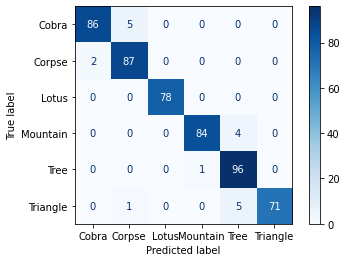

In [ ]:
accuracy = accuracy_score(actions[np.argmax(y_test_DL,axis =1).tolist()],
                          actions[np.argmax(y_test_predict, axis=1).tolist()])

precision = precision_score(actions[np.argmax(y_test_DL,axis =1).tolist()],
                            actions[np.argmax(y_test_predict, axis=1).tolist()],
                            average='macro')

recall = recall_score(actions[np.argmax(y_test_DL,axis =1).tolist()],
                      actions[np.argmax(y_test_predict, axis=1).tolist()],
                      average='macro')

f1 = f1_score(actions[np.argmax(y_test_DL,axis =1).tolist()],
              actions[np.argmax(y_test_predict, axis=1).tolist()],
              average='macro')


ConfusionMatrixDisplay.from_predictions(actions[np.argmax(y_test_DL,axis =1).tolist()], 
                                        actions[np.argmax(y_test_predict, axis=1).tolist()], 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')

In [ ]:
scoring_list.append(dict([
    ('Model', 'LSTM'),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3))
     ]))

In [ ]:
model_lstm.save('/progetto_tesi/model_LSTM/')

INFO:tensorflow:Assets written to: /progetto_tesi/model_LSTM/assets


INFO:tensorflow:Assets written to: /progetto_tesi/model_LSTM/assets


##### **Classificazione con GRU**

In [ ]:
log_dir =os.path.join("\\progetto_tesi",'Logs_GRU')
tb_callback = TensorBoard(log_dir = log_dir)

In [ ]:
model_gru= Sequential()

model_gru.add(GRU(64, return_sequences=True, activation='relu', input_shape=(45,51)))
model_gru.add(GRU(128, return_sequences=True, activation='relu'))
model_gru.add(GRU(64, return_sequences=False, activation='relu'))
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dense(32, activation='relu'))
model_gru.add(Dense(actions.shape[0], activation='softmax'))


In [ ]:
model_gru.compile(optimizer ='Adam', 
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [ ]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 45, 64)            22464     
                                                                 
 gru_1 (GRU)                 (None, 45, 128)           74496     
                                                                 
 gru_2 (GRU)                 (None, 64)                37248     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 6)                 198       
                                                                 
Total params: 140,646
Trainable params: 140,646
Non-tr

In [ ]:
gru_h=model_gru.fit(X_train, y_train_DL, epochs=100, callbacks =[tb_callback])

Epoch 1/100
65/65 [==============================] - 14s 90ms/step - loss: 1.3102 - categorical_accuracy: 0.5127
Epoch 2/100
65/65 [==============================] - 6s 92ms/step - loss: 0.5395 - categorical_accuracy: 0.7912
Epoch 3/100
65/65 [==============================] - 6s 97ms/step - loss: 0.3044 - categorical_accuracy: 0.8971
Epoch 4/100
65/65 [==============================] - 7s 112ms/step - loss: 0.2882 - categorical_accuracy: 0.8980
Epoch 5/100
65/65 [==============================] - 6s 99ms/step - loss: 0.2257 - categorical_accuracy: 0.9216
Epoch 6/100
65/65 [==============================] - 7s 102ms/step - loss: 0.2418 - categorical_accuracy: 0.9173
Epoch 7/100
65/65 [==============================] - 6s 99ms/step - loss: 0.2001 - categorical_accuracy: 0.9360
Epoch 8/100
65/65 [==============================] - 7s 103ms/step - loss: 0.1565 - categorical_accuracy: 0.9543
Epoch 9/100
65/65 [==============================] - 7s 103ms/step - loss: 0.1539 - categorical_accu

In [ ]:
y_test_predict = model_gru.predict(X_test)

17/17 [==============================] - 2s 35ms/step


accuracy: 0.9826923076923076
accuracy: 0.9826923076923076
precision: 0.9826634118066703
recall: 0.9833161596887995
f1: 0.9829539964492509


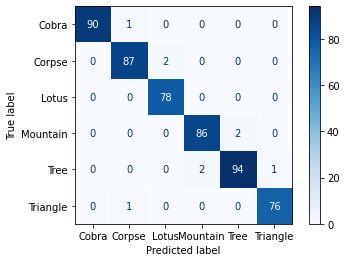

In [ ]:
accuracy = accuracy_score(actions[np.argmax(y_test_DL,axis =1).tolist()],
                          actions[np.argmax(y_test_predict, axis=1).tolist()])

precision = precision_score(actions[np.argmax(y_test_DL,axis =1).tolist()],
                            actions[np.argmax(y_test_predict, axis=1).tolist()],
                            average='macro')

recall = recall_score(actions[np.argmax(y_test_DL,axis =1).tolist()],
                      actions[np.argmax(y_test_predict, axis=1).tolist()],
                      average='macro')

f1 = f1_score(actions[np.argmax(y_test_DL,axis =1).tolist()],
              actions[np.argmax(y_test_predict, axis=1).tolist()],
              average='macro')


ConfusionMatrixDisplay.from_predictions(actions[np.argmax(y_test_DL,axis =1).tolist()], 
                                        actions[np.argmax(y_test_predict, axis=1).tolist()], 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')

In [ ]:
scoring_list.append(dict([
    ('Model', 'GRU'),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3))
     ]))

In [ ]:
model_gru.save('/progetto_tesi/model_GRU/')

INFO:tensorflow:Assets written to: /progetto_tesi/model_GRU/assets


INFO:tensorflow:Assets written to: /progetto_tesi/model_GRU/assets


### **Confronto Riassiuntivo**

Confrontiamo ora i vari modelli di reti neurali ricorrenti

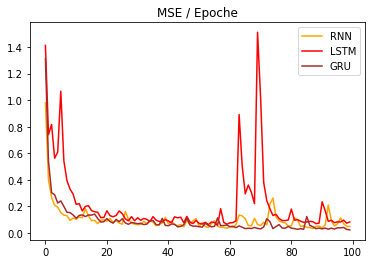

<Figure size 1440x864 with 0 Axes>

In [ ]:
#grafico del Loss
f, ax = plt.subplots()
plt.figure(figsize=(20,12))
ax.set_title('MSE / Epoche')
ax.plot(rnn_h.history['loss'], color='orange')
ax.plot(lstm_h.history['loss'], color = 'red')
ax.plot(gru_h.history['loss'], color = 'brown')
ax.legend(['RNN', 'LSTM', 'GRU'], loc = 0)
plt.show()

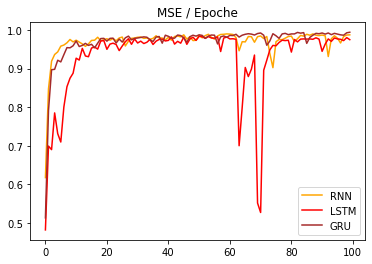

<Figure size 1440x864 with 0 Axes>

In [ ]:
#grafico dell'accuratezza
f, ax = plt.subplots()
plt.figure(figsize=(20,12))
ax.set_title('MSE / Epoche')
ax.plot(rnn_h.history['categorical_accuracy'], color='orange')
ax.plot(lstm_h.history['categorical_accuracy'], color = 'red')
ax.plot(gru_h.history['categorical_accuracy'], color = 'brown')
ax.legend(['RNN', 'LSTM', 'GRU'], loc = 0)
plt.show()

Ora confrontiamo i vari modelli secondo le metriche usate

In [ ]:
results = pd.DataFrame(data=scoring_list)
results = results[['Model',
                   'Test Accuracy',
                   'Precision',
                   'Recall',
                   'F1']]

results = results.sort_values(by='Recall', ascending=False)

results

,Model,Test Accuracy,Precision,Recall,F1
0,SVM,0.983,0.984,0.983,0.983
4,GRU,0.983,0.983,0.983,0.983
2,RNN,0.979,0.979,0.979,0.979
1,Random Forest,0.977,0.979,0.977,0.978
3,LSTM,0.965,0.969,0.965,0.966


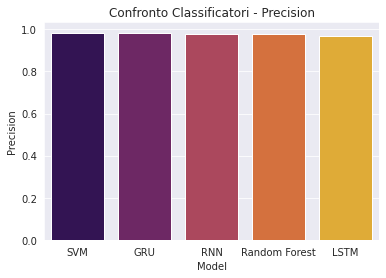

In [ ]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = results,
                x=results['Model'],
                y=results['Precision'],
                palette = 'inferno').set(title = "Confronto Classificatori - Precision")

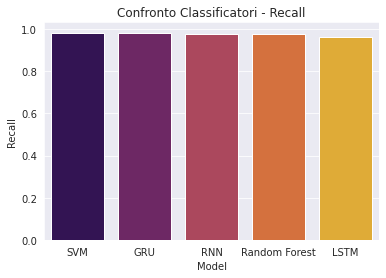

In [ ]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = results,
                x=results['Model'],
                y=results['Recall'],
                palette = 'inferno').set(title = "Confronto Classificatori - Recall")

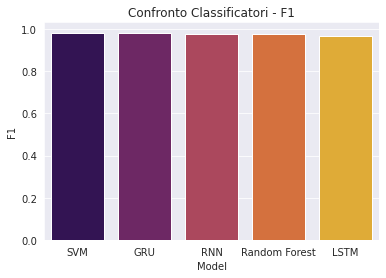

In [ ]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = results,
                x=results['Model'],
                y=results['F1'],
                palette = 'inferno').set(title = "Confronto Classificatori - F1")

### **Conclusioni e approfondimento**

Come si può notare tutti i modelli, a partire da quelli più semplici, fino ad arrivare a quelli deep hanno prodotto dei risultati fin troppo ottimi, pertanto potremmo essere andati incontro al fenmeno dell'ovevrfitting.Per valutare quindi in maniera più corretta la situazione proviamo ad addestrate e trainare i modelli utilizzando la tecnica del **Leave one person Out**.


Per fare questo dovrò prima ottenere gli indici sui quali dividere la x e la Y, in modo tale da lasciare ogni volta una sola persona fuori.Per fare questo sfrutto il vettore group_sequences creato durante la creazione del dataset.

In [186]:
people_index=[]
flag=[]
for value in range(0,np.max(group_sequences)+1):
    person=[]
    i=0
    while i < len(group_sequences):
        if group_sequences[i] == value:
            person.append(i)
        else:
            flag.append(i)
        i=i+1
    people_index.append(person)
    #i=flag[-1]#in modo tale che non riparta dall'inizio ma dal primo valore diverso trovato
    
    

Proviamo a creare i nostri x, y train e x,y test considerno come set di test la fold che contiene solamente i video apparteneti alla persona a cui è stata associata l'identificativo 0

In [215]:
new_y_test = np.array([sample for sample in y[people_index[0]]])
new_X_test = np.array([sample for sample in X[people_index[0]]])

Troviamo gli indici delle altre persone che andranno a comporre il set di training

In [216]:
reamainig_people = [index for tupl in people_index[1:] for index in tupl]

In [217]:
new_y_train = np.array([sample for sample in y[reamainig_people]])
new_X_train = np.array([sample for sample in X[reamainig_people]])

Possiamo osservare che il risultato otenuto è corretto in quanto i valori delle shape sono complementari : 
*164 + 2435 = 2599*

In [218]:
print(new_X_test.shape)
print(new_X_train.shape)
print(new_y_test.shape)
print(new_y_train.shape)

(164, 45, 51)
(2435, 45, 51)
(164,)
(2435,)


Ripeto lo stesso passaggio effettuato precedentemente per poter usare i modelli 'semplici' e quelli deep.

In [219]:
new_X_train_ML = new_X_train.reshape(2435,(45*51))
new_X_test_ML = new_X_test.reshape(164,(45*51))

In [221]:
print(new_X_train_ML.shape)
print(new_X_test_ML.shape)
print(new_y_train.shape)
print(new_y_test.shape)


(2435, 2295)
(164, 2295)
(2435,)
(164,)


In [233]:
new_y_test_DL = to_categorical(new_y_test).astype(int)
new_y_train_DL= to_categorical(new_y_train).astype(int)

In [234]:
print(new_y_test_DL.shape)
print(new_y_train_DL.shape)

(164, 6)
(2435, 6)


##### **SVM**

Per addestrae SVM utilizzo come iper-parametri i parametri indivuati nella fasse precedente di validation
**classifier__C': 10, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf'}**

In [224]:
model_svm = SVC(C= 10, gamma = 0.01, kernel = 'rbf')

In [226]:
model_svm.fit(new_X_train_ML, new_y_train)
y_test_predict = model_svm.predict(new_X_test_ML)

accuracy: 0.9817073170731707
precision: 0.9827160493827161
recall: 0.9852801519468186
f1: 0.9836940691447649


[]

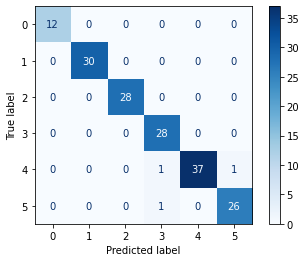

In [230]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(new_y_test, y_test_predict)
precision = precision_score(new_y_test, y_test_predict, average='macro')
recall = recall_score(new_y_test, y_test_predict, average='macro')
f1 = f1_score(new_y_test, y_test_predict, average='macro')

ConfusionMatrixDisplay.from_predictions(new_y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')


plt.plot()

##### **RANDOM FOREST**

Per addestrae RANDOM FOREST utilizzo come iper-parametri i parametri indivuati nella fasse precedente di validation
**{'classifier__max_depth': 10, 'classifier__n_estimators': 200}**

In [231]:
model_rf= RandomForestClassifier(max_depth=10,n_estimators=200)

model_rf.fit(new_X_train_ML, new_y_train)
y_test_predict = model_rf.predict(new_X_test_ML)

accuracy: 0.9634146341463414
precision: 0.9662835249042147
recall: 0.9634615384615385
f1: 0.9635691755829056


[]

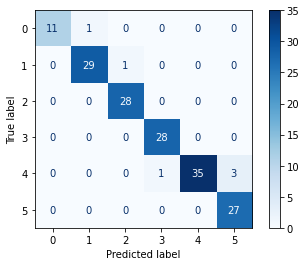

In [232]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(new_y_test, y_test_predict)
precision = precision_score(new_y_test, y_test_predict, average='macro')
recall = recall_score(new_y_test, y_test_predict, average='macro')
f1 = f1_score(new_y_test, y_test_predict, average='macro')

ConfusionMatrixDisplay.from_predictions(new_y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')


plt.plot()

##### **LSTM**

In [235]:
new_model_lstm= Sequential()

new_model_lstm.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(45,51)))
new_model_lstm.add(LSTM(128, return_sequences=True, activation='relu'))
new_model_lstm.add(LSTM(64, return_sequences=False, activation='relu'))
new_model_lstm.add(Dense(64, activation='relu'))
new_model_lstm.add(Dense(32, activation='relu'))
new_model_lstm.add(Dense(actions.shape[0], activation='softmax'))

In [236]:
new_model_lstm.compile(optimizer ='Adam', 
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [239]:
lstm_h=new_model_lstm.fit(new_X_train, new_y_train_DL, epochs=50)

Epoch 1/50
77/77 [==============================] - 13s 95ms/step - loss: 1.6380 - categorical_accuracy: 0.4312
Epoch 2/50
77/77 [==============================] - 7s 92ms/step - loss: 1.0730 - categorical_accuracy: 0.5967
Epoch 3/50
77/77 [==============================] - 7s 92ms/step - loss: 0.7792 - categorical_accuracy: 0.7150
Epoch 4/50
77/77 [==============================] - 7s 93ms/step - loss: 0.5359 - categorical_accuracy: 0.8341
Epoch 5/50
77/77 [==============================] - 7s 94ms/step - loss: 0.7129 - categorical_accuracy: 0.7770
Epoch 6/50
77/77 [==============================] - 7s 96ms/step - loss: 66.3654 - categorical_accuracy: 0.7811
Epoch 7/50
77/77 [==============================] - 8s 104ms/step - loss: 27.4977 - categorical_accuracy: 0.3647
Epoch 8/50
77/77 [==============================] - 7s 95ms/step - loss: 1.0724 - categorical_accuracy: 0.5622
Epoch 9/50
77/77 [==============================] - 7s 96ms/step - loss: 0.7813 - categorical_accuracy: 0.68

In [240]:
y_test_predict = new_model_lstm.predict(new_X_test)

6/6 [==============================] - 1s 36ms/step


accuracy: 0.9329268292682927
accuracy: 0.9329268292682927
precision: 0.9468759018759019
recall: 0.9281779948446616
f1: 0.9362302974883733


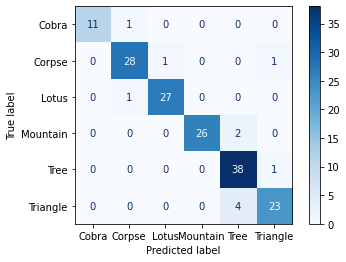

In [242]:
accuracy = accuracy_score(actions[np.argmax(new_y_test_DL,axis =1).tolist()],
                          actions[np.argmax(y_test_predict, axis=1).tolist()])

precision = precision_score(actions[np.argmax(new_y_test_DL,axis =1).tolist()],
                            actions[np.argmax(y_test_predict, axis=1).tolist()],
                            average='macro')

recall = recall_score(actions[np.argmax(new_y_test_DL,axis =1).tolist()],
                      actions[np.argmax(y_test_predict, axis=1).tolist()],
                      average='macro')

f1 = f1_score(actions[np.argmax(new_y_test_DL,axis =1).tolist()],
              actions[np.argmax(y_test_predict, axis=1).tolist()],
              average='macro')


ConfusionMatrixDisplay.from_predictions(actions[np.argmax(new_y_test_DL,axis =1).tolist()], 
                                        actions[np.argmax(y_test_predict, axis=1).tolist()], 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')

##### **GRU**

In [243]:
new_model_gru= Sequential()

new_model_gru.add(GRU(64, return_sequences=True, activation='relu', input_shape=(45,51)))
new_model_gru.add(GRU(128, return_sequences=True, activation='relu'))
new_model_gru.add(GRU(64, return_sequences=False, activation='relu'))
new_model_gru.add(Dense(64, activation='relu'))
new_model_gru.add(Dense(32, activation='relu'))
new_model_gru.add(Dense(actions.shape[0], activation='softmax'))

In [244]:
new_model_gru.compile(optimizer ='Adam', 
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [245]:
gru_h=new_model_gru.fit(new_X_train, new_y_train_DL, epochs=50)

Epoch 1/50
77/77 [==============================] - 14s 81ms/step - loss: 1.0167 - categorical_accuracy: 0.6353
Epoch 2/50
77/77 [==============================] - 6s 81ms/step - loss: 0.5270 - categorical_accuracy: 0.7552
Epoch 3/50
77/77 [==============================] - 6s 82ms/step - loss: 0.3843 - categorical_accuracy: 0.8427
Epoch 4/50
77/77 [==============================] - 6s 82ms/step - loss: 0.3079 - categorical_accuracy: 0.8867
Epoch 5/50
77/77 [==============================] - 6s 83ms/step - loss: 0.2514 - categorical_accuracy: 0.9129
Epoch 6/50
77/77 [==============================] - 6s 82ms/step - loss: 0.1848 - categorical_accuracy: 0.9470
Epoch 7/50
77/77 [==============================] - 6s 82ms/step - loss: 0.2943 - categorical_accuracy: 0.9043
Epoch 8/50
77/77 [==============================] - 6s 82ms/step - loss: 0.1427 - categorical_accuracy: 0.9598
Epoch 9/50
77/77 [==============================] - 6s 82ms/step - loss: 0.1460 - categorical_accuracy: 0.9569


accuracy: 0.9329268292682927
accuracy: 0.9329268292682927
precision: 0.9468759018759019
recall: 0.9281779948446616
f1: 0.9362302974883733


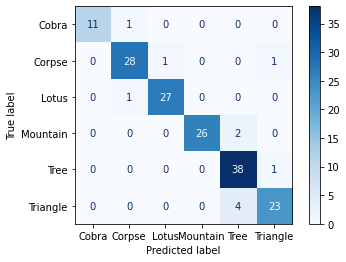

In [246]:
accuracy = accuracy_score(actions[np.argmax(new_y_test_DL,axis =1).tolist()],
                          actions[np.argmax(y_test_predict, axis=1).tolist()])

precision = precision_score(actions[np.argmax(new_y_test_DL,axis =1).tolist()],
                            actions[np.argmax(y_test_predict, axis=1).tolist()],
                            average='macro')

recall = recall_score(actions[np.argmax(new_y_test_DL,axis =1).tolist()],
                      actions[np.argmax(y_test_predict, axis=1).tolist()],
                      average='macro')

f1 = f1_score(actions[np.argmax(new_y_test_DL,axis =1).tolist()],
              actions[np.argmax(y_test_predict, axis=1).tolist()],
              average='macro')


ConfusionMatrixDisplay.from_predictions(actions[np.argmax(new_y_test_DL,axis =1).tolist()], 
                                        actions[np.argmax(y_test_predict, axis=1).tolist()], 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')

Poichè i risultati ottenuti sono equivalenti a quelli ottenuti precedenti possiamo affermare che prima i nostri modelli non soffrivano di over-fitting e lo si può appurare anche dal fatto che i modelli funzionano bene anche in real-time.


Quindi ora proviamo ad addestrare i nostri modelli effettuando un shuffle sul nostro dataset poichè la struttura sequenziale del nostro dataset potrebbe influenzare i risultati dei nostri modelli, specialmente i modelli deep.Utilizzo ora il dataset iniziale e non quello creato per il leave one person out

In [257]:
shuffle_X_train, shuffle_y_DL_train = shuffle(X_train, y_train_DL, random_state=11)

In [258]:
shuffle_model_gru= Sequential()

shuffle_model_gru.add(GRU(64, return_sequences=True, activation='relu', input_shape=(45,51)))
shuffle_model_gru.add(GRU(128, return_sequences=True, activation='relu'))
shuffle_model_gru.add(GRU(64, return_sequences=False, activation='relu'))
shuffle_model_gru.add(Dense(64, activation='relu'))
shuffle_model_gru.add(Dense(32, activation='relu'))
shuffle_model_gru.add(Dense(actions.shape[0], activation='softmax'))


In [259]:
shuffle_model_gru.compile(optimizer ='Adam', 
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [260]:
gru_h=shuffle_model_gru.fit(shuffle_X_train, shuffle_y_DL_train, epochs=50)

Epoch 1/50
65/65 [==============================] - 12s 83ms/step - loss: 1.1556 - categorical_accuracy: 0.5993
Epoch 2/50
65/65 [==============================] - 6s 86ms/step - loss: 0.4946 - categorical_accuracy: 0.7951
Epoch 3/50
65/65 [==============================] - 6s 85ms/step - loss: 0.4167 - categorical_accuracy: 0.8389
Epoch 4/50
65/65 [==============================] - 6s 86ms/step - loss: 0.2805 - categorical_accuracy: 0.8923
Epoch 5/50
65/65 [==============================] - 5s 84ms/step - loss: 0.2349 - categorical_accuracy: 0.9197
Epoch 6/50
65/65 [==============================] - 5s 84ms/step - loss: 0.2542 - categorical_accuracy: 0.9158
Epoch 7/50
65/65 [==============================] - 6s 85ms/step - loss: 0.1582 - categorical_accuracy: 0.9495
Epoch 8/50
65/65 [==============================] - 6s 86ms/step - loss: 0.1704 - categorical_accuracy: 0.9452
Epoch 9/50
65/65 [==============================] - 5s 85ms/step - loss: 0.1643 - categorical_accuracy: 0.9519


In [261]:
y_test_predict = shuffle_model_gru.predict(X_test)

17/17 [==============================] - 1s 29ms/step


accuracy: 0.9826923076923076
accuracy: 0.9826923076923076
precision: 0.9831364648640396
recall: 0.982584497404085
f1: 0.9828074512724124


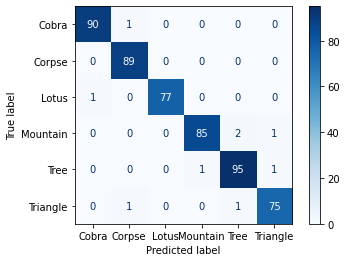

In [262]:
accuracy = accuracy_score(actions[np.argmax(y_test_DL,axis =1).tolist()],
                          actions[np.argmax(y_test_predict, axis=1).tolist()])

precision = precision_score(actions[np.argmax(y_test_DL,axis =1).tolist()],
                            actions[np.argmax(y_test_predict, axis=1).tolist()],
                            average='macro')

recall = recall_score(actions[np.argmax(y_test_DL,axis =1).tolist()],
                      actions[np.argmax(y_test_predict, axis=1).tolist()],
                      average='macro')

f1 = f1_score(actions[np.argmax(y_test_DL,axis =1).tolist()],
              actions[np.argmax(y_test_predict, axis=1).tolist()],
              average='macro')


ConfusionMatrixDisplay.from_predictions(actions[np.argmax(y_test_DL,axis =1).tolist()], 
                                        actions[np.argmax(y_test_predict, axis=1).tolist()], 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')

I risultati ottenuti sono ugual ai primi 

Prova in real-time

Definisco una funzione che mostri a schermo la propabilità con la quale la posa che si sta eseguendo appartenga ad una delle 6 classi

In [ ]:
def prob_viz(res,actions,input_frame):
    output_frame =input_frame
    for num, pro in enumerate(res):
        cv2.rectangle(output_frame,(0,60+num*40), 
                      (int(pro*100), 90+num*40),(255,0,255), -1)
        cv2.putText(output_frame, actions[num], (0,85+num*40), 
                    cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2, cv2.LINE_AA)
    return output_frame

In [ ]:
sequence=[]
predictions=[]
posa=''

cap = cv2.VideoCapture(0) 
# Load the input image.
image_height, image_width = [480,640]
crop_region = init_crop_region(image_height, image_width)
while cap.isOpened():
    ret,frame = cap.read()
    image = frame
    
    keypoints_with_scores = run_inference(
    movenet, image, crop_region,
    crop_size=[256, 256])

    crop_region = determine_crop_region(
    keypoints_with_scores, image_height, image_width)
    draw_skeleton(frame, keypoints_with_scores, 0.3)

    #predict logic 
    keypoint = extract_keypoints(keypoints_with_scores)
    sequence.append(keypoint)
    sequence= sequence[-45:]
    
    if len(sequence)==45:
        res = model_Rnn.predict(np.expand_dims(sequence,axis=0))[0]
        predictions.append(np.argmax(res))
    
        #scrivere su schermo la scritta
        if np.unique(predictions[-10:])[0]==np.argmax(res):# controlla che le ultime 10 predizioni siano uguali
            if res[np.argmax(res)] > 0.3:
                posa = actions[np.argmax(res)]

         
        image = prob_viz(res,actions, image)
    
    cv2.rectangle(image, (0,0), (640,40), (245,117,16), -1)
    cv2.putText(image, posa, (3,30), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2, cv2.LINE_AA)
    
    cv2.imshow('MoveNet', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 46ms/step


## **2. Correzione della posa**

In questa seconda fase del sistema verrà implementato un sistema che, come anticipato, permetterà la correzione della posa che si sta eseguendo.

Si è deciso di implentare questo sistema sfruttando l'algoritmo **K Nearest Neighbors** **KNN**, il quale troverà il frame o i frame più simili (farà una media tra questi frame calcolando il centroide) al frame che si sta predendo in considerazione .

A questo punto verranno calcolati gli angoli sia per il centroide che per il frame preso in considerazione  e verranno confrontati.

Importo i moduli e le librerie di interesse, utili per la realizzazione di questa fase del sistema.

In [ ]:
from sklearn.neighbors import NearestNeighbors

### **Dataset**

#### **Creazione del dataset**

Per la correzione della posa si è deciso di non utilizzare il dataset creato per la fase precedente ma di creare un dataset apposito per ogni posa in modo tale che fosse più facile lavorare con dataset di dimensioni ridotte e con una struttura più facile da navigare;Inoltre lavorare con un dataset di dimensioni ridotte comporta sicuramente anche un minor costo computazionale.

Più in dettaglio il vecchio dataset aveva una composizione di questo tipo: 

- *[Vettore contenente tutti i video composti da 45 frame[Vettore contenente 45 vettori di keypoint[vettore contenente 51 punti 17 punti * 3(x,y,confidence)]]]*                                         
Quindi una shape di questo tipo **(2599, 45, 51)**

Mentre il nuovo dataset avrà la seguente composizione per ogni posa:

- *[Vettore contenete  tutti i frame[vettore contenente 51 punti 17 punti * 3(x,y,confidence)]]*      
Quindi una shape di questo tipo **(17517, 51)**

Definisco la funzione per creare il dataset per ogni posa

In [ ]:
def create_pose_dataset(pose):
    dataset_pose=[]

    file_path = os.path.join(DATA_PATH, pose)
            
    key_dir_list = []
    for f in os.listdir(file_path):
        name, ext = os.path.splitext(f)
        if not ext == '.mp4':
            key_dir_list.append(f)
                
    i=0
    for keypoint_dir in key_dir_list:
        for frame_num in range(1, info_videos[label_map[pose]][1][i][1]):#sostituire 5 forse con label map
            window = []
            frame_path = np.load(os.path.join(file_path,keypoint_dir,"{}.npy".format(frame_num)))
            window.append(frame_path)
            dataset_pose.append(window)
        i+=1
    return np.array(dataset_pose)
    

Creo effettivamente i vari dataset

In [ ]:
dataset_Cobra=create_pose_dataset('Cobra')
dataset_Corpse=create_pose_dataset('Corpse')
dataset_Lotus=create_pose_dataset('Lotus')
dataset_Mountain=create_pose_dataset('Mountain')
dataset_Tree=create_pose_dataset('Tree')
dataset_Triangle=create_pose_dataset('Triangle')

Si noti come i dataset abbiao dimensione (17517, 1, 51), dove 1 indica che i video sono composti da 1 frame.

In [ ]:
print(dataset_Cobra.shape)
print(dataset_Corpse.shape)
print(dataset_Lotus.shape)
print(dataset_Mountain.shape)
print(dataset_Tree.shape)
print(dataset_Triangle.shape)

(20721, 1, 51)
(20492, 1, 51)
(17884, 1, 51)
(20061, 1, 51)
(22204, 1, 51)
(17517, 1, 51)


Dobbiamo pertanto ricondurci alla shape descritta all'inizio (17517, 51), pertanto applico la seguente funzione

In [ ]:
#numpy.squeeze() returns numpy.ndarray with all dimensions of size 1 removed.
dataset_Cobra=np.squeeze(dataset_Cobra)
dataset_Corpse=np.squeeze(dataset_Corpse)
dataset_Lotus=np.squeeze(dataset_Lotus)
dataset_Mountain=np.squeeze(dataset_Mountain)
dataset_Tree=np.squeeze(dataset_Tree)
dataset_Triangle=np.squeeze(dataset_Triangle)

In [ ]:
print(dataset_Cobra.shape)
print(dataset_Corpse.shape)
print(dataset_Lotus.shape)
print(dataset_Mountain.shape)
print(dataset_Tree.shape)
print(dataset_Triangle.shape)

(20721, 51)
(20492, 51)
(17884, 51)
(20061, 51)
(22204, 51)
(17517, 51)


Per poter semplicare acond di più l'accesso ai valori x,y per ogni keypoint effettuo il seguente reshape al dataset. 

In [ ]:
dataset_Cobra=dataset_Cobra.reshape(20721, 17,3)
dataset_Corpse=dataset_Corpse.reshape(20492, 17,3)
dataset_Lotus=dataset_Lotus.reshape(17884, 17,3)
dataset_Mountain=dataset_Mountain.reshape(20061, 17,3)
dataset_Tree=dataset_Tree.reshape(22204, 17,3)
dataset_Triangle=dataset_Triangle.reshape(17517, 17,3)

In [ ]:
print(dataset_Cobra.shape)
print(dataset_Corpse.shape)
print(dataset_Lotus.shape)
print(dataset_Mountain.shape)
print(dataset_Tree.shape)
print(dataset_Triangle.shape)

(20721, 17, 3)
(20492, 17, 3)
(17884, 17, 3)
(20061, 17, 3)
(22204, 17, 3)
(17517, 17, 3)


In [ ]:
npy_path = os.path.join("./dataset_checker/","dataset_Cobra")
np.save(npy_path, dataset_Cobra)
npy_path = os.path.join("./dataset_checker/","dataset_Corpse")
np.save(npy_path, dataset_Corpse)   
npy_path = os.path.join("./dataset_checker/","dataset_Lotus")
np.save(npy_path, dataset_Lotus)   
npy_path = os.path.join("./dataset_checker/","dataset_Mountain")
np.save(npy_path, dataset_Mountain)   
npy_path = os.path.join("./dataset_checker/","dataset_Tree")
np.save(npy_path, dataset_Tree)   
npy_path = os.path.join("./dataset_checker/","dataset_Triangle")
np.save(npy_path, dataset_Triangle)   

Definisco un dizionario che vada a definire quali sono gli **angoli** che andremo a calcolare sulla base dei 17 punti individuati da MoveNet 

In [ ]:
ANGL_DICT = {
    'angl_left_elbow': [10,8,6],
    'angl_left_shoulder': [8,6,12],
    'angl_left_hip': [6,12,14],
    'angl_left_knee': [12,14,16],
    'angl_right_elbow': [9,7,5],
    'angl_right_shoulder': [7,5,11],
    'angl_right_hip': [5,11,13],
    'angl_right_knee': [11,13,15],
}

Definisco la funzione che calcola i gradi di un angolo a partire da 3 vettori dati in input, contenenti i valory di x e y per oguno dei 3 punti presi in considerazione

In [ ]:
def calculate_angle(a,b,c):
#a,b e c sono array e dovrebbero essere composti da punti x,y, e confidence
    a=np.array(a) #first 
    b=np.array(b) #mid
    c=np.array(c) #end

    radians = np.arctan2(c[1]-b[1], c[0]-b[0])- np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = int(np.abs(radians*180.0/np.pi))

    if angle > 180.0:
        angle = 360 - angle
    
    return angle

Definisco una funzione che mi andrà a calcolare gli angoli per tutti 17 i punti individuati da MoveNet

In [ ]:
def calculate_all_angles(keypoints):
    agles_list=[]
    for key in ANGL_DICT:
            first_point=keypoints[ANGL_DICT[key][0]]
            second_point=keypoints[ANGL_DICT[key][1]]
            third_point=keypoints[ANGL_DICT[key][2]]
            angle=calculate_angle(first_point,second_point,third_point)
            agles_list.append([key,angle])
    return agles_list
    
    

Definisco una funzione che implementi il KNN, che quindi trovi 1 o più frame vicini, faccia la media calcolando il centroide e che calcoli infine per questo frame trovato gli angoli per tutti i 17 punti.

In [ ]:
def knn_angoli(n_neighbors,samples,keypoint):
    two_dimension_samples=samples.reshape(samples.shape[0], 51)
    
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(two_dimension_samples)
    
    two_dimension_keypoint = keypoint.reshape(1, -1)
    index=neigh.kneighbors(two_dimension_keypoint,#keypoint/frame
                        n_neighbors=n_neighbors, return_distance=False)
    #print(index)
    #print(index.shape)
    #print(index[0][0])
    #print(samples[index[0][0]])
    
    if(n_neighbors==1):
        angles_vid=calculate_all_angles(samples[index[0][0]])
    else:
        centroide=np.zeros((17,3))
        i=0
        for j in index[0]:

            centroide+=samples[j]
            i+=1
        centroide=centroide/i
        
        angles_vid=calculate_all_angles(centroide)
    
    return angles_vid
    

Definisco una funzione che verifichi la correttezza degli angoli generati dalla posa esguita

In [ ]:
def correct_angles(threshold, angles_vid, angles_u):
    for i in range(len(angles_vid)):
        diff=abs(angles_vid[i][1] - angles_u[i][1])
        if diff < threshold:
            print("angolo sbagliato di: ", diff)
            print(angles_vid[i][0])
            

Per ogni posa definisco una funzione che verifichi la correttezza degli angoli e che dia un feedback

In [ ]:
def correct_angles(threshold, angles_vid, angles_u,posa):
    if posa == 'Cobra':
        correct_angles_cobra(threshold, angles_vid, angles_u)
    elif posa== 'Corpse':
        correct_angles_corpse(threshold, angles_vid, angles_u)        
    elif posa== 'Lotus':
        correct_angles_lotus(threshold, angles_vid, angles_u)
    elif posa== 'Mountain':
        correct_angles_mountain(threshold, angles_vid, angles_u)        
    elif posa== 'Tree':
        correct_angles_tree(threshold, angles_vid, angles_u)        
    elif posa== 'Triangle':
        correct_angles_triangle(threshold, angles_vid, angles_u)
        

In [ ]:
def correct_angles_cobra(threshold, angles_vid, angles_u):

    for i in range(len(angles_vid)):
        diff=abs(angles_vid[i][1] - angles_u[i][1])
        if diff > threshold:
            if i == 0 or i == 4:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Distendi le braccia")
            elif i == 2 or i == 5:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Mantieni le mani larghezza spalle")
            elif i == 3 or i == 6:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Mantieni le gambe largezza spalle")
            elif i == 4 or i == 7:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Distendi le gambe")
            else :
                print("posizione corretta")              
                

In [ ]:
def correct_angles_corpse(threshold, angles_vid, angles_u):
    for i in range(len(angles_vid)):
        diff=abs(angles_vid[i][1] - angles_u[i][1])
        if diff > threshold:
            if i == 0 or i == 4:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Distendi meglio le braccia")
            elif i == 2 or i == 5:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Disponi le braccia lungo i fianchi")
            elif i == 3 or i == 6:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Mantieni le gambe largezza spalle")
            elif i == 4 or i == 7:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Distendi meglio le gambe")
            else :
                print("posizione corretta")    

In [ ]:
def correct_angles_lotus(threshold, angles_vid, angles_u):
    for i in range(len(angles_vid)):
        diff=abs(angles_vid[i][1] - angles_u[i][1])
        if diff > threshold:
            if i == 0 or i == 4:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Distendi meglio le braccia")
            elif i == 2 or i == 5:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Mantenendo il busto dritto lascia cadere le braccia")#TO DO scrivere qualcosa di meglio
            elif i == 3 or i == 6:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Mantieni le gambe largezza spalle")
            elif i == 4 or i == 7:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Incrocia meglio le gambe")
            else :
                print("posizione corretta")  

In [ ]:
def correct_angles_mountain(threshold, angles_vid, angles_u):
    for i in range(len(angles_vid)):
        diff=abs(angles_vid[i][1] - angles_u[i][1])
        if diff > threshold:
            if i == 0 or i == 4:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Distendi meglio le braccia")
            elif i == 2 or i == 5:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Tira manggiormente le braccia verticalmente")
            elif i == 3 or i == 6:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Mantieni le gambe largezza spalle")
            elif i == 4 or i == 7:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Distendi meglio le gambe e sali maggiormente sulle punte dei piedi")
            else :
                print("posizione corretta")  

In [ ]:
def correct_angles_tree(threshold, angles_vid, angles_u):
    for i in range(len(angles_vid)):
        diff=abs(angles_vid[i][1] - angles_u[i][1])
        if diff > threshold:
            if i == 0 or i == 4:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Unendo le mani cerca di fomare un angolo retto con il gomito")
            elif i == 2 or i == 5:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Non tenere i gomiti esternamente ma lasciali vicino al corpo")
            elif i == 3 or i == 6:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Mantieni le gambe largezza spalle piegandone una")
            elif i == 4 or i == 7:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Distendi meglio una gamba e cerca di portare il piede in prossimità del ginochhio")
            else :
                print("posizione corretta")  

In [ ]:
def correct_angles_triangle(threshold, angles_vid, angles_u):
    for i in range(len(angles_vid)):
        diff=abs(angles_vid[i][1] - angles_u[i][1])
        if diff > threshold:
            if i == 0 or i == 4:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Distedi meglio le braccia ")
            elif i == 2 or i == 5:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Disponi le braccia orizzontalmente e cerca di piegarti maggiormente verso la punta del piede")#TO DO scrivere qualcosa di meglio
            elif i == 3 or i == 6:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Metti le gambe un po' più larghe rispetto alle spalle")
            elif i == 4 or i == 7:
                print("Angolo {} sbagliato di: {} gradi".format(angles_vid[i][0], diff))
                print("Mantieni le gambe distese")
            else :
                print("posizione corretta")  

Definisco una funzione che mostri a schermo gli angoli

In [ ]:
def draw_angles(angles_u,input_frame):
    output_frame =input_frame
    for i in range(len(angles_u)):
        cv2.putText(output_frame, angles_u[i][0]+": "+ str(angles_u[i][1]), (450,85+i*40), 
                    cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),1, cv2.LINE_AA)
    return output_frame

Prova in real-time

In [ ]:
cap = cv2.VideoCapture(0) 
# Load the input image.
image_height, image_width = [480,640]
crop_region = init_crop_region(image_height, image_width)
while cap.isOpened():
    ret,frame = cap.read()
    image = frame
    
    keypoints_with_scores = run_inference(
    movenet, image, crop_region,
    crop_size=[256, 256])

    crop_region = determine_crop_region(
    keypoints_with_scores, image_height, image_width)
    draw_skeleton(frame, keypoints_with_scores, 0.3)

    keypoint = extract_keypoints(keypoints_with_scores)

    angl_vid=knn_angoli(4,dataset_Triangle,keypoint)


    keypoint = keypoint.reshape((17,3))      
    angl_u=calculate_all_angles(keypoint)

    image = draw_angles(angl_u,image)
    
    #correct_angles(15,angl_vid,angl_u)
    
    
    cv2.imshow('MoveNet', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()


## **Demo del sistema completo**

Demo del sistema completo in cui avvien sia la classificazione che la correzione delle pose di yoga

In [ ]:
sequence=[]
predictions=[]
posa='nessuno'
dataset_posa=None

cap = cv2.VideoCapture(0) 
# Load the input image.
image_height, image_width = [480,640]
crop_region = init_crop_region(image_height, image_width)
while cap.isOpened():
    ret,frame = cap.read()
    image = frame
    
    keypoints_with_scores = run_inference(
    movenet, image, crop_region,
    crop_size=[256, 256])

    crop_region = determine_crop_region(
    keypoints_with_scores, image_height, image_width)
    draw_skeleton(frame, keypoints_with_scores, 0.3)

    #predict logic 
    keypoint = extract_keypoints(keypoints_with_scores)
    sequence.append(keypoint)
    sequence= sequence[-45:]
    
    if len(sequence)==45:
        res = model_Rnn.predict(np.expand_dims(sequence,axis=0))[0]
        predictions.append(np.argmax(res))
    
        #scrivere su schermo la scritta
        if np.unique(predictions[-10:])[0]==np.argmax(res):# controlla che le ultime 10 predizioni siano uguali
            if res[np.argmax(res)] > 0.3:
                posa = actions[np.argmax(res)]
                dataset_posa = eval('dataset_'+ posa)#fa il parsing tra stringa e variabile
         
        image = prob_viz(res,actions, image)
    
    cv2.rectangle(image, (0,0), (640,40), (245,117,16), -1)
    cv2.putText(image, posa, (3,30), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2, cv2.LINE_AA)
    
    if posa != 'nessuno':
        angl_vid=knn_angoli(4,dataset_posa,keypoint)


        keypoint = keypoint.reshape((17,3))      
        angl_u=calculate_all_angles(keypoint)

        image = draw_angles(angl_u,image)
        
        correct_angles(15,angl_vid,angl_u,posa)
    
    cv2.imshow('MoveNet', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 364ms/step
Angolo angl_left_hip sbagliato di: 4 gradi
Disponi le braccia lungo i fianchi
1/1 [==============================] - 0s 106ms/step
Angolo angl_left_hip sbagliato di: 7 gradi
Disponi le braccia lungo i fianchi
1/1 [==============================] - 0s 83ms/step
posizione corretta
1/1 [==============================] - 0s 70ms/step
Angolo angl_left_hip sbagliato di: 9 gradi
Disponi le braccia lungo i fianchi
Angolo angl_left_knee sbagliato di: 9 gradi
Mantieni le gambe largezza spalle
1/1 [==============================] - 0s 95ms/step
posizione corretta
Angolo angl_left_hip sbagliato di: 13 gradi
Disponi le braccia lungo i fianchi
Angolo angl_left_knee sbagliato di: 11 gradi
Mantieni le gambe largezza spalle
1/1 [==============================] - 0s 82ms/step
Angolo angl_left_hip sbagliato di: 10 gradi
Disponi le braccia lungo i fianchi
1/1 [==============================] - 0s 96ms/step
Angolo angl_right_elbow sbagliato di: 9 gradi
D